In [67]:
import numpy as np
import pandas as pd

In [68]:
import os
import glob

In [69]:
from scipy.optimize import curve_fit

In [70]:
import matplotlib.pyplot as plt

In [71]:
import numpy as np
from scipy.special import wofz  # Faddeeva function for Voigt profile
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [72]:
#loading dopplers
folder_path = 'spectroscopy_data/doppler/'
csv_files = glob.glob(os.path.join(folder_path, '*.CSV')) 
print(csv_files)


['spectroscopy_data/doppler/doppler (2).CSV', 'spectroscopy_data/doppler/doppler (3).CSV', 'spectroscopy_data/doppler/doppler (4).CSV', 'spectroscopy_data/doppler/doppler (1).CSV']


- 1 Loaded spectroscopy_data/doppler/doppler (1).CSV:
- 2 Loaded spectroscopy_data/doppler/doppler (2).CSV:
- 3 Loaded spectroscopy_data/doppler/doppler (3).CSV:
- 4 Loaded spectroscopy_data/doppler/doppler (4).CSV:

In [73]:
temp = csv_files[0]
csv_files[0] = csv_files[3]
csv_files[3] = temp
temp = csv_files[3]
csv_files[3] = csv_files[2]
csv_files[2] = temp
temp  = csv_files[2]
csv_files[2] = csv_files[1]
csv_files[1]  =temp


In [74]:
dataframes_doppler = []
i=0
for file in csv_files:
    i +=1
    df = pd.read_csv(file)
    dataframes_doppler.append(df)
    print(f"{i} Loaded {file}:") 

1 Loaded spectroscopy_data/doppler/doppler (1).CSV:
2 Loaded spectroscopy_data/doppler/doppler (2).CSV:
3 Loaded spectroscopy_data/doppler/doppler (3).CSV:
4 Loaded spectroscopy_data/doppler/doppler (4).CSV:


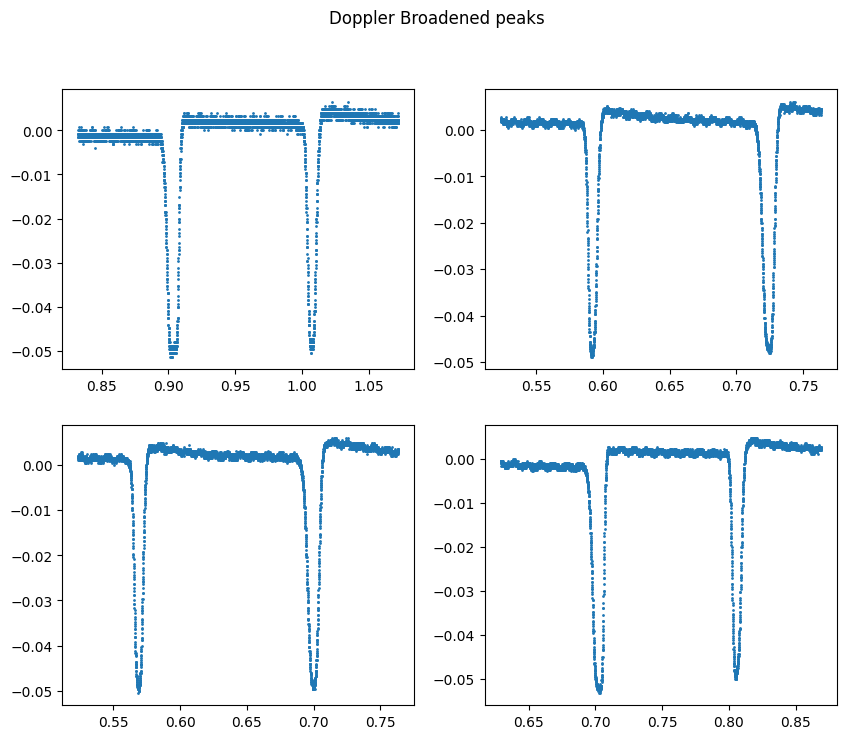

In [75]:
#fitting Doppler 
# problem - missing the CH2!! idk which dip is which..
fig, axs = plt.subplots(2,2 , figsize=(10, 8))

fig.suptitle('Doppler Broadened peaks')
for i in range(4):
    axs[i//2 , i%2].scatter(dataframes_doppler[i]['[s]'], dataframes_doppler[i]['CH1[V]'], s=1)

### gaussian fits on Doppler Broadened Peaks
Objective : Get the energy to time Conversion rate.
- fit each dip inside a measuremnt set with a gaussian
- for each set of 2 fits - get the distance
- compare the distance - get the erorrs

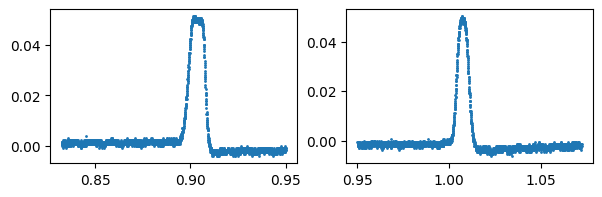

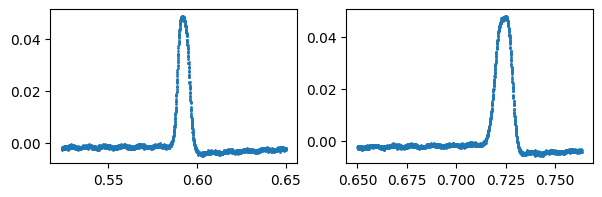

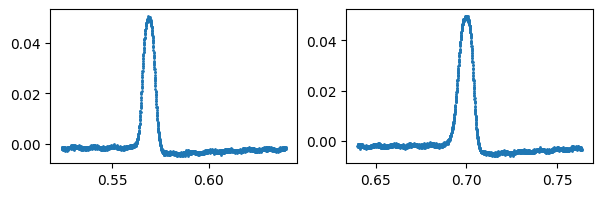

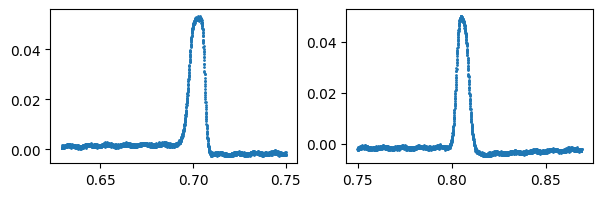

In [76]:
# df_doppler_edited = []
df_doppler_edited = np.ones((4,2), dtype=object)
cuts = [0.95, 0.65, 0.64, 0.75]

for i in range(4):
    df = dataframes_doppler[i]
    df['CH1[V]'] *= -1

    cut_index = (df['[s]'] - cuts[i]).abs().argmin()
    df1 = df.iloc[:cut_index]
    # df_doppler_edited.append(df1)
    df_doppler_edited[i, 0] = df1
    df2 = df.iloc[cut_index:]
    # df_doppler_edited.append(df2)
    df_doppler_edited[i, 1] = df2
    fig, axs = plt.subplots(1,2, figsize = (7,2))
    axs[0].scatter(df1['[s]'], df1['CH1[V]'], s=1)
    axs[ 1].scatter(df2['[s]'], df2['CH1[V]'], s=1)

# portioned dips / peaks saved in df_doppler_edited

In [77]:
#normalize
for i in range(4):
    for j in range(2):
        df_doppler_edited[i,j].loc[:,'CH1[V]'] = df_doppler_edited[i,j]['CH1[V]'] / df_doppler_edited[i,j]['CH1[V]'].abs().max()

In [78]:
#peak guesses
p0_peaks = [0.902, 1.008, 0.593, 0.725, 0.57, 0.7, 0.702, 0.805]
p0_peaks = np.array(p0_peaks).reshape(4,2)

In [79]:
#cut an area around the peak

for i in range(4):
    for j in range(2):

        # df_rn  = df_doppler_edited[i, j]
        # print(df_doppler_edited[i, j].head())

        left = p0_peaks[i, j] - 0.015
        right = p0_peaks[i, j] + 0.015
        # print(left, right)

        new_cut1  = (df_doppler_edited[i,j]['[s]'] - left).abs().argmin()
        new_cut2  = (df_doppler_edited[i,j]['[s]'] - right).abs().argmin()
        df_doppler_edited[i,j] = df_doppler_edited[i,j].iloc[new_cut1:new_cut2]
        # print(len(df_doppler_edited[i,j]))

In [80]:
# fit function
def gauss(x, x0, sigma, A): 
    return A * np.exp(-np.square(x - x0) / (2 * np.square(sigma)))

[0.90307669 0.00352561 1.09789566]
[1.00733841 0.00258219 1.06332413]
[ 0.59210066 -0.00263891  1.07653853]
[ 0.72385114 -0.00342585  1.08418091]
[0.56877397 0.0025864  1.06268966]
[0.69950757 0.00332986 1.07183591]
[0.70187198 0.00342421 1.08815606]
[0.80569917 0.00261707 1.06517889]


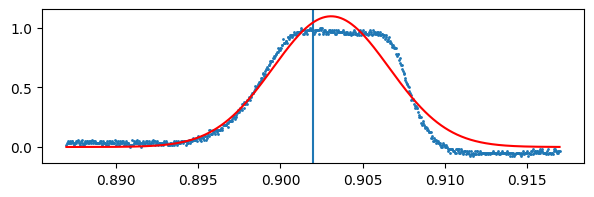

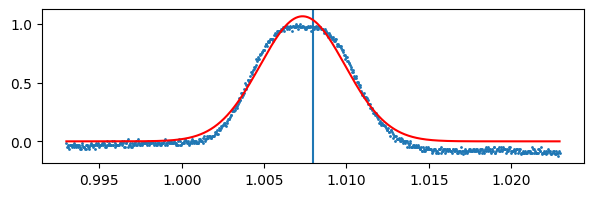

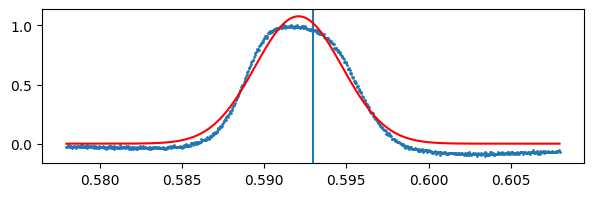

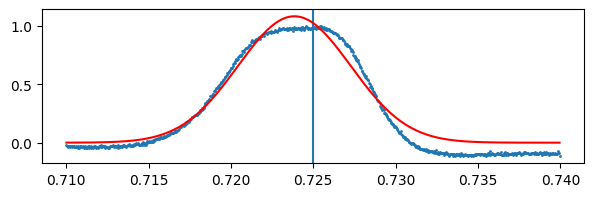

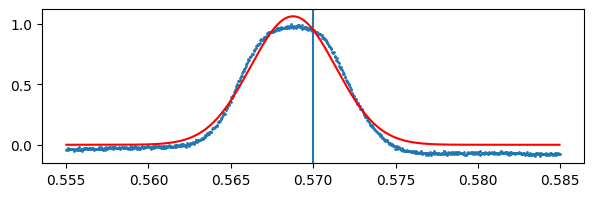

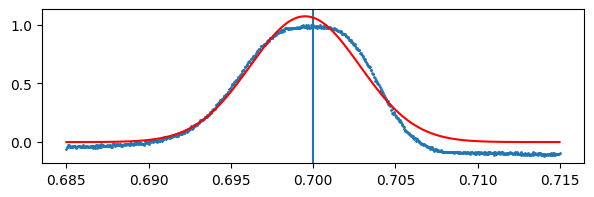

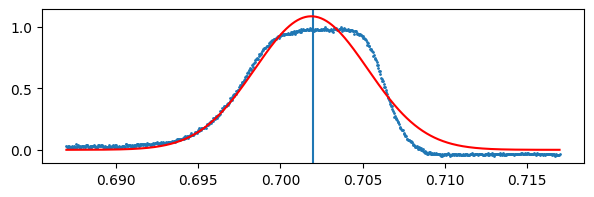

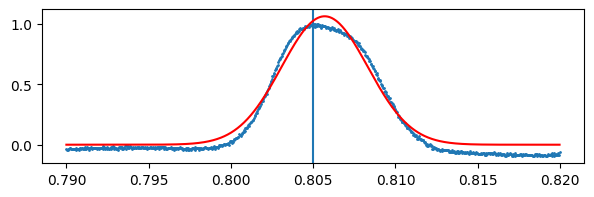

In [81]:
params  = np.zeros((4,2), dtype = object)
covs  = np.zeros((4,2), dtype = object)

for i in range(4):
    for j in range(2):
        p0 = [p0_peaks[i,j], 0.04,1]
        params[i,j], covs[i,j] = curve_fit(gauss, df_doppler_edited[i,j]['[s]'], df_doppler_edited[i,j]['CH1[V]'], p0 = p0)
        fit_y = gauss(df_doppler_edited[i,j]['[s]'], params[i,j][0], params[i,j][1], params[i,j][2]) 
        print(params[i,j])
        #plot
        xdat  =df_doppler_edited[i,j]['[s]']
        ydat = df_doppler_edited[i,j]['CH1[V]']

        fig, ax = plt.subplots( figsize = (7,2))
        ax.scatter(xdat, ydat, s=1)
        ax.axvline(p0_peaks[i,j])
        ax.plot(xdat, fit_y, color= 'red')

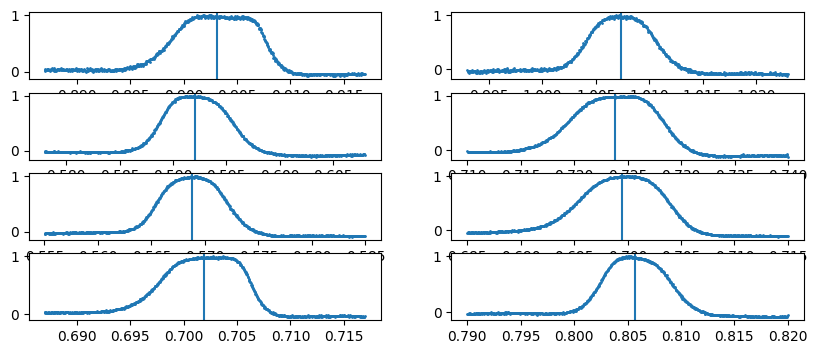

In [82]:
fig, axs = plt.subplots(4,2, figsize = (10,4))

for i in range(4):
    for j in range(2):
        xdat  =df_doppler_edited[i,j]['[s]']
        ydat = df_doppler_edited[i,j]['CH1[V]']
        axs[i,j].scatter(xdat, ydat, s=1)
        axs[i,j].axvline(params[i,j][0])


In [83]:
distances = np.zeros(4)

for i in range(4):
    distances[i] = params[i,0][0] - params[i,1][0]
distances

print('conversion distance', abs(np.average(distances)), np.std(distances))

conversion distance 0.11764324786376995 0.013604412868899164


In [84]:
print(distances)

[-0.10426172 -0.13175048 -0.1307336  -0.10382719]


### importing hyperfine peaks and ascertaining distances

In [85]:
#loading 6 peaks
folder_path = 'spectroscopy_data/peaks_6'
csv_files = glob.glob(os.path.join(folder_path, '*.CSV')) 
dataframes6peaks = []
i=0
for file in csv_files:
    i +=1
    df = pd.read_csv(file)
    dataframes6peaks.append(df)
    print(f"{i} Loaded {file}:")  # Display first few rows of each file


1 Loaded spectroscopy_data/peaks_6/6_ (10).CSV:
2 Loaded spectroscopy_data/peaks_6/6_ (1).CSV:
3 Loaded spectroscopy_data/peaks_6/6_ (7).CSV:
4 Loaded spectroscopy_data/peaks_6/6_ (6).CSV:
5 Loaded spectroscopy_data/peaks_6/6_ (5).CSV:
6 Loaded spectroscopy_data/peaks_6/CS-BB-22.CSV:
7 Loaded spectroscopy_data/peaks_6/CS-BB-23.CSV:
8 Loaded spectroscopy_data/peaks_6/6_ (9).CSV:
9 Loaded spectroscopy_data/peaks_6/6_ (8).CSV:
10 Loaded spectroscopy_data/peaks_6/6_ (4).CSV:
11 Loaded spectroscopy_data/peaks_6/6_ (3).CSV:
12 Loaded spectroscopy_data/peaks_6/6_ (2).CSV:


In [86]:
#loading 5 peaks
folder_path = 'spectroscopy_data/peaks_5'
csv_files = glob.glob(os.path.join(folder_path, '*.CSV')) 
dataframes5peaks = []
i=0
for file in csv_files:
    i +=1
    df = pd.read_csv(file)
    dataframes5peaks.append(df)
    print(f"{i} Loaded {file}:") 

1 Loaded spectroscopy_data/peaks_5/5_ (4).CSV:
2 Loaded spectroscopy_data/peaks_5/5_ (8).CSV:
3 Loaded spectroscopy_data/peaks_5/5_ (9).CSV:
4 Loaded spectroscopy_data/peaks_5/5_ (5).CSV:
5 Loaded spectroscopy_data/peaks_5/5_ (2).CSV:
6 Loaded spectroscopy_data/peaks_5/5_ (3).CSV:
7 Loaded spectroscopy_data/peaks_5/5_ (1).CSV:
8 Loaded spectroscopy_data/peaks_5/5_ (6).CSV:
9 Loaded spectroscopy_data/peaks_5/5_ (10).CSV:
10 Loaded spectroscopy_data/peaks_5/5_ (11).CSV:
11 Loaded spectroscopy_data/peaks_5/5_ (7).CSV:


In [ ]:
xdat = dataframes5peaks[0]['[s]']
subtracty = -1*gauss(xdat, 0.96, params[0,0][1], params[0,0][2])*np.max(dataframes5peaks[0]['CH1[V]'].abs())
ydat = dataframes5peaks[0]['CH1[V]']
subtracted = np.subtract(ydat , subtracty)


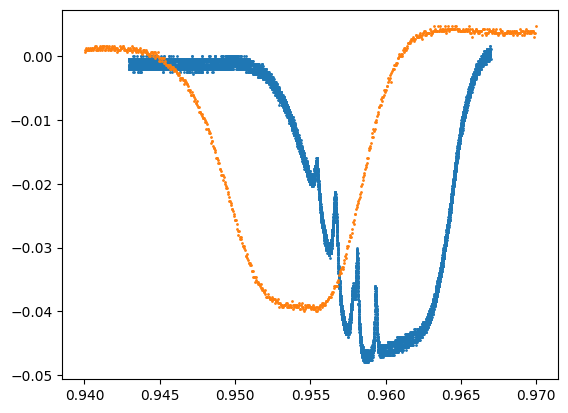

In [ ]:
plt.scatter(xdat, ydat,s=1)
# plt.xlim(left = 0.95, right = 0.96)
# plt.scatter(xdat, subtracty,s=1)
# plt.scatter(xdat, subtracted,s=1)
plt.scatter(df_doppler_edited[1,1]['[s]']+0.23, -0.04*df_doppler_edited[1,1]['CH1[V]'], s=1)
# plt.scatter(dataframes5peaks[0]['[s]'], dataframes5peaks[0]['CH2[V]'],s=1)